# Refactor Network Charts 

Refactor network charts code to place geometry placement code in its own "mixin"...

In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dmt.tk.plotting.shapes import Circle, Arc, PolarPoint
from dmt.tk.plotting.charts.network import CircularNetworkChart

In [2]:
N = 6
mtypes = ["L23_MC", "L5_TPC:A", "L6_UPC", "L23_BC", "L1_SBC", "L4_TPC"][:N]
sclasses = pd.Series(
    ["INH", "EXC", "EXC", "INH", "INH", "EXC"][:N],
    index=mtypes, name="sclass")
pathways = [
    (pre_mtype, post_mtype)
    for pre_mtype in mtypes
    for post_mtype in mtypes]
N = len(pathways)
pathway_strength = pd.DataFrame(
    {("pathway_strength", "mean"): np.random.uniform(size=N),
     ("pathway_strength", "std"):  np.random.uniform(size=N)},
    index=pd.MultiIndex.from_tuples(
        pathways,
        names=["pre_mtype", "post_mtype"]))
def get_node_weights(dataframe):
    weights = dataframe.groupby("pre_mtype").agg("sum")[("pathway_strength", "mean")]
    weights.index.name = "label"
    weights.name = "weight"
    return weights/np.sum(weights)

link_weights = pd.Series(
    pathway_strength[("pathway_strength", "mean")].values,
    index = pathway_strength.index.rename(["begin_node", "end_node"]),
    name="weight")

In [3]:
layer_cols = {'L1': np.array([0.3, 0.3, 0]),
              'L2': np.array([0.0, 0.3, 0.3]),
              'L3': np.array([0.15, 0.3, 0.15]),
              'L4': np.array([0.3, 0.0, 0.3]),
              'L5': np.array([0.0, 0.6, 0.0]),
              'L6': np.array([0.1, 0.1, 0.4])}
layer_cols["L23"] = (layer_cols["L2"] + layer_cols["L3"]) / 2.

default = np.array([0.2, 0.2, 0.2])
add_ei = {'EXC': np.array([0.5, 0.0, 0.0]),
          'INH': np.array([0.0, 0.0, 0.5])}


def _get_color(mtype, sclass):
    layer = mtype.split('_')[0]
    return np.minimum(
        layer_cols[layer]
            + add_ei[sclass] 
            + np.random.rand(3) * 0.25, 1.0)
def make_col_dict(mtypes):
    return dict([(_m[0], numpy.minimum(layer_cols.setdefault(_m[0][1], default)
                                       + add_ei[_m[1]] +
                                       numpy.random.rand(3) * 0.25, 1.0))
                 for _m in mtypes])

In [4]:
mtypes = link_weights.index.get_level_values("begin_node").unique()
color_map ={
    mtype: _get_color(mtype, sclass)
    for mtype, sclass in sclasses.items()}
for pre in mtypes:
    for post in mtypes:
        link_color = list(color_map[pre])
        link_color.append(0.25)
        color_map[(pre, post)] = np.array([0.8, 0.8, 0.8, 1.0]) * link_color
chart =\
    CircularNetworkChart(
        link_data=link_weights,
        color_map=color_map)

In [5]:
chart.link_data.groupby(
    "begin_node"
).agg(
    "sum"
).rename(
    "outgoing"
)

begin_node
L1_SBC      3.406515
L23_BC      3.509261
L23_MC      4.532329
L4_TPC      2.083321
L5_TPC:A    2.571556
L6_UPC      2.301797
Name: outgoing, dtype: float64

In [6]:
chart.node_flow

,outgoing,incoming,total
L1_SBC,3.406515,3.313922,6.720437
L23_BC,3.509261,2.702132,6.211393
L23_MC,4.532329,3.460312,7.992642
L4_TPC,2.083321,1.547241,3.630562
L5_TPC:A,2.571556,3.816301,6.387857
L6_UPC,2.301797,3.564871,5.866668


In [7]:
chart.node_weight

,total,source,target
L1_SBC,0.182573,0.092544,0.090029
L23_BC,0.168744,0.095336,0.073408
L23_MC,0.217135,0.123129,0.094006
L4_TPC,0.098631,0.056597,0.042034
L5_TPC:A,0.173538,0.069861,0.103677
L6_UPC,0.159379,0.062533,0.096846


In [8]:
chart.node_position

,source,target
L1_SBC,"(1.0, 0.2180523898971094)","(0.9, 0.6482302344243623)"
L23_BC,"(1.0, 1.3467842425582608)","(0.9, 1.7443779794681715)"
L23_MC,"(1.0, 2.46925815019587)","(0.9, 2.9808703179335057)"
L4_TPC,"(1.0, 3.597519879447968)","(0.9, 3.829913605535083)"
L5_TPC:A,"(1.0, 4.355358817874723)","(0.9, 4.764248081501456)"
L6_UPC,"(1.0, 5.417669360689038)","(0.9, 5.793197111992736)"


In [9]:
chart.node_geometry_size.total

L1_SBC       (0.1, 0.860355689054506)
L23_BC      (0.1, 0.7951874738198218)
L23_MC      (0.1, 1.0232243354752708)
L4_TPC      (0.1, 0.4647874521742305)
L5_TPC:A    (0.1, 0.8177785272534641)
L6_UPC      (0.1, 0.7510555026073958)
Name: total, dtype: object

In [10]:
node_one = chart.node_data.iloc[0]
node_one.position.source

(1.0, 0.2180523898971094)

In [11]:
PolarPoint(
    *node_one.position.source)

PolarPoint(radial=1.0, angular=0.2180523898971094)

In [12]:
chart.get_source_geometry("L1_SBC", chart.node_data.loc["L1_SBC"])

In [13]:
chart.get_target_geometry("L1_SBC", chart.node_data.loc["L1_SBC"])

<Figure size 864x864 with 0 Axes>

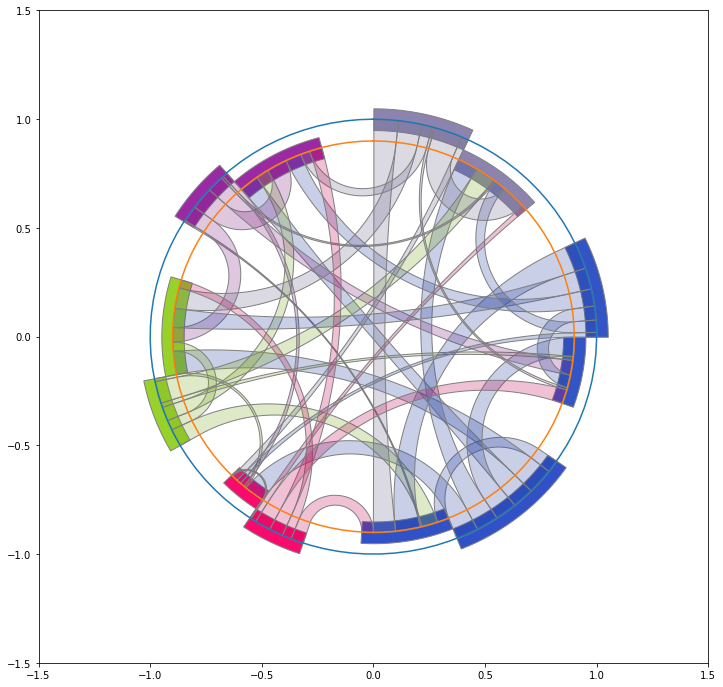

In [14]:
figure = plt.figure(figsize=(12, 12))
axes = figure.add_axes()
chart.draw(draw_diagonal=False)

In [15]:
PolarPoint(*PolarPoint(1, 0))

PolarPoint(radial=1, angular=0)

In [16]:
from collections import OrderedDict
flows = list(chart.flow_geometries.values())
flow_size = pd.DataFrame(
    [
        OrderedDict([("begin", flow.size_begin),("end", flow.size_end)])
        for flow in chart.flow_geometries.values()
    ],
    index=pd.MultiIndex.from_tuples(
        [flow.label for flow in chart.flow_geometries.values()],
        names=["begin_node", "end_node"])
)
print(chart.node_geometry_size.loc["L6_UPC"].target[1])
flow_size.xs(
    "L6_UPC", level="end_node"
)

0.45637761477540123


,begin,end
begin_node,,
L23_MC,0.098337,0.098337
L5_TPC:A,0.065097,0.065097
L6_UPC,0.103151,0.103151
L23_BC,0.079629,0.079629
L1_SBC,0.047498,0.047498
L4_TPC,0.062667,0.062667


In [17]:
chart.flow_data.xs(
    "L6_UPC", level="end_node")

,weight,begin,end
begin_node,,,
L23_MC,0.041735,0.098337,0.098337
L5_TPC:A,0.027628,0.065097,0.065097
L6_UPC,0.043779,0.103151,0.103151
L23_BC,0.033795,0.079629,0.079629
L1_SBC,0.020159,0.047498,0.047498
L4_TPC,0.026597,0.062667,0.062667


In [18]:
chart.node_angular_size

,total,source,target
L1_SBC,0.860356,0.436105,0.424251
L23_BC,0.795187,0.449258,0.345929
L23_MC,1.023224,0.580232,0.442992
L4_TPC,0.464787,0.266708,0.198079
L5_TPC:A,0.817779,0.329213,0.488566
L6_UPC,0.751056,0.294678,0.456378


In [19]:
def _angular_size(dataframe):
    return dataframe.apply(
        lambda row: pd.Series(dict(
            source = row.source[1],
            target = row.target[1])),
        axis=1
    )
posize = pd.concat(
    [_angular_size(chart.node_position),
     _angular_size(chart.node_geometry_size)],
    axis=1,
    keys=["position", "geometry_size"]
)
posize

position           geometry_size          
            source    target        source    target
L1_SBC    0.218052  0.648230      0.436105  0.424251
L23_BC    1.346784  1.744378      0.449258  0.345929
L23_MC    2.469258  2.980870      0.580232  0.442992
L4_TPC    3.597520  3.829914      0.266708  0.198079
L5_TPC:A  4.355359  4.764248      0.329213  0.488566
L6_UPC    5.417669  5.793197      0.294678  0.456378

In [20]:
chart.flow_geometry_size.head()

begin       end
begin_node end_node                    
L23_MC     L23_MC    0.058813  0.058813
           L5_TPC:A  0.120399  0.120399
           L6_UPC    0.098337  0.098337
           L23_BC    0.099125  0.099125
           L1_SBC    0.101931  0.101931

In [21]:
figure

<Figure size 864x864 with 0 Axes>

In [22]:
chart.node_geometry_size.source

L1_SBC       (0.1, 0.4361047797942188)
L23_BC      (0.1, 0.44925833140921123)
L23_MC       (0.1, 0.5802324234464862)
L4_TPC      (0.1, 0.26670843540184147)
L5_TPC:A    (0.1, 0.32921263230859227)
L6_UPC       (0.1, 0.2946778878319946)
Name: source, dtype: object

In [23]:
l23_MC = chart.source_geometries["L23_MC"]
l23_MC.shape

PolarPoint(radial=(0.95, 1.05), angular=(2.1791419384726267, 2.759374361919113))

In [24]:
chart.node_data.geometry_size.loc["L23_MC"].source

(0.1, 0.5802324234464862)

In [25]:
chart.center

array([0., 0.])

In [26]:
l23mc =  chart.source_geometries["L23_MC"]

In [27]:
l23mc.shape.radial

(0.95, 1.05)

In [28]:
l23mc.shape.angular

(2.1791419384726267, 2.759374361919113)

In [29]:
chart.get_source_geometry(
    "L23_MC",
    chart.node_data.loc["L23_MC"]
).shape

PolarPoint(radial=(0.95, 1.05), angular=(2.1791419384726267, 2.759374361919113))

In [30]:
chart.node_data.loc["L23_MC"]

position       source        (1.0, 2.46925815019587)
               target      (0.9, 2.9808703179335057)
geometry_size  total       (0.1, 1.0232243354752708)
               source      (0.1, 0.5802324234464862)
               target      (0.1, 0.4429919120287847)
weight         total                        0.217135
               source                       0.123129
               target                      0.0940058
flow           outgoing                      4.53233
               incoming                      3.46031
               total                         7.99264
Name: L23_MC, dtype: object

In [31]:
PolarPoint(*chart.node_data.loc["L23_MC"].position.source)

PolarPoint(radial=1.0, angular=2.46925815019587)

In [32]:
chart.node_geometry_size

,total,source,target
L1_SBC,"(0.1, 0.860355689054506)","(0.1, 0.4361047797942188)","(0.1, 0.42425090926028713)"
L23_BC,"(0.1, 0.7951874738198218)","(0.1, 0.44925833140921123)","(0.1, 0.34592914241061046)"
L23_MC,"(0.1, 1.0232243354752708)","(0.1, 0.5802324234464862)","(0.1, 0.4429919120287847)"
L4_TPC,"(0.1, 0.4647874521742305)","(0.1, 0.26670843540184147)","(0.1, 0.19807901677238907)"
L5_TPC:A,"(0.1, 0.8177785272534641)","(0.1, 0.32921263230859227)","(0.1, 0.48856589494487196)"
L6_UPC,"(0.1, 0.7510555026073958)","(0.1, 0.2946778878319946)","(0.1, 0.45637761477540123)"


In [33]:
chart.node_geometry_size.apply(
    lambda s: pd.Series(dict(total=s.total[1], source=s.source[1], target=s.target[1])),
    axis=1)

,total,source,target
L1_SBC,0.860356,0.436105,0.424251
L23_BC,0.795187,0.449258,0.345929
L23_MC,1.023224,0.580232,0.442992
L4_TPC,0.464787,0.266708,0.198079
L5_TPC:A,0.817779,0.329213,0.488566
L6_UPC,0.751056,0.294678,0.456378


In [34]:
chart.node_position

,source,target
L1_SBC,"(1.0, 0.2180523898971094)","(0.9, 0.6482302344243623)"
L23_BC,"(1.0, 1.3467842425582608)","(0.9, 1.7443779794681715)"
L23_MC,"(1.0, 2.46925815019587)","(0.9, 2.9808703179335057)"
L4_TPC,"(1.0, 3.597519879447968)","(0.9, 3.829913605535083)"
L5_TPC:A,"(1.0, 4.355358817874723)","(0.9, 4.764248081501456)"
L6_UPC,"(1.0, 5.417669360689038)","(0.9, 5.793197111992736)"


In [35]:
 number_nodes = chart.node_weight.shape[0]
 spacing = 2. * np.pi * chart.spacing_factor / number_nodes

 def _positions_angular():
     position_end = - spacing
     for size in chart.node_geometry_size.total.values:
         position_start = position_end + spacing
         position_end = position_start + size[1]
         yield (position_start + position_end) / 2.

positions_angular = pd.Series(
    list(_positions_angular()),
        index=chart.node_geometry_size.index,
        name="angular"
)
node_geometry_size_angular = chart.node_geometry_size.apply(
    lambda node_size: pd.Series(dict(
        total=node_size.total[1],
        source=node_size.source[1],
        target=node_size.target[1])),
        axis=1
)
starts_source = (
    positions_angular - node_geometry_size_angular.total[1] / 2.
).rename(
    "start_source"
)
positions_angular_source = (
    starts_source + node_geometry_size_angular.source[1] / 2.
).rename(
    "angular"
)
positions_source = positions_angular_source.apply(
    lambda position_angular: (chart.outer_circle.radius, position_angular)
)
starts_target = (
    positions_angular_source + node_geometry_size_angular.source[1] / 2.
).rename(
    "start_target"
)
positions_angular_target = (
    starts_target + node_geometry_size_angular.target[1] / 2.
).rename(
    "angular"
)
positions_target = positions_angular_target.apply(
    lambda position_angular: (
        chart.inner_circle.radius, position_angular)
)

In [36]:
positions_target

L1_SBC      (0.9, 0.6548070102318586)
L23_BC      (0.9, 1.7443779794681715)
L23_MC       (0.9, 2.915383271914868)
L4_TPC      (0.9, 3.9211885535387685)
L5_TPC:A     (0.9, 4.824270931051766)
L6_UPC      (0.9, 5.8704873337813455)
Name: angular, dtype: object